# A2 - Bone vs Living Community Analysis

This notebook builds a reproducible workflow to compare bone assemblages with aerial census data across Ol Pejeta Conservancy (OPC).

In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

try:
    import skbio
    from skbio.diversity import beta_diversity
    from skbio.stats.distance import permanova, DistanceMatrix
except ImportError as exc:  # pragma: no cover
    raise ImportError("scikit-bio is required. Install with `pip install scikit-bio`." ) from exc

from scipy.stats import pearsonr, spearmanr, mannwhitneyu

from IPython.display import display

## Introduction & goals

This notebook follows the A2 analysis plan to evaluate whether the bone community reflects the living community and whether bone assemblages capture changes before and after fence removal (2007).

In [191]:
# Configuration
CONFIG = {
    "census_path": "../data/export/excel/a2_df_census_ol_pejeta_by_sector.xlsx",
    "bones_path": "../data/export/excel/a2_df_bone_census_ol_pejeta_by_sector.xlsx",
    "species_col": "Species",
    "row_total_label": "Row_Total",
    "column_total_label": "Column_Total",
    "row_total_col": "Row_Total",
    "min_occurrence_prop": 0.2,  # species must appear in at least this proportion of samples
    "random_state": 42,
    "post_fence_year": 2007,
}

SHEET_SECTOR_MAP = {
    "Eastern": "E",
    "Western": "W",
}

np.random.seed(CONFIG["random_state"])


## Data loading & cleaning

In [192]:
def tidy_sheet(df: pd.DataFrame, species_col: str, value_name: str, sector: str, sample_name: str) -> pd.DataFrame:
    """Convert a wide sheet into long format with species, sample, and counts."""
    df = df.rename(columns={species_col: "species"})
    # Drop total column if present
    if CONFIG["row_total_col"] in df.columns:
        df = df.drop(columns=[CONFIG["row_total_col"]])
    # Drop total rows if present
    drop_labels = {CONFIG["row_total_label"]}
    if CONFIG.get("column_total_label"):
        drop_labels.add(CONFIG["column_total_label"])
    df = df[~df["species"].str.strip().isin(drop_labels)]

    df["species"] = df["species"].str.strip()
    df = df.melt(id_vars=["species"], var_name=sample_name, value_name=value_name)
    df[sample_name] = pd.to_numeric(df[sample_name], errors="coerce")
    df[value_name] = pd.to_numeric(df[value_name], errors="coerce")
    df = df.dropna(subset=[sample_name, value_name])
    df[sample_name] = df[sample_name].astype(int)
    df[value_name] = df[value_name].astype(int)
    df["sector"] = sector.upper()
    return df


def load_dataset(path: str, value_name: str, sample_name: str) -> pd.DataFrame:
    """Load configured sector sheets from an Excel file into a long DataFrame."""
    frames = []
    xls = pd.ExcelFile(path)
    for sheet, sector in SHEET_SECTOR_MAP.items():
        if sheet not in xls.sheet_names:
            continue
        sheet_df = pd.read_excel(path, sheet_name=sheet)
        frame = tidy_sheet(sheet_df, CONFIG["species_col"], value_name=value_name, sector=sector, sample_name=sample_name)
        frame["sheet"] = sheet
        frames.append(frame)
    df = pd.concat(frames, ignore_index=True)
    df["sector"] = df["sector"].str.strip().str.upper().replace({"EAST": "E", "WEST": "W", "EASTERN": "E", "WESTERN": "W"})
    return df

# Load data
census_long = load_dataset(CONFIG["census_path"], value_name="count", sample_name="year")
bones_long = load_dataset(CONFIG["bones_path"], value_name="count", sample_name="death_year_estimate")

census_long.head(), bones_long.head()


(                     species  year  count sector    sheet
 0           Acinonyx jubatus  2005      0      E  Eastern
 1         Aepyceros melampus  2005    226      E  Eastern
 2      Alcelaphus buselaphus  2005      6      E  Eastern
 3            Canis mesomelas  2005      0      E  Eastern
 4  Ceratotherium simum simum  2005      0      E  Eastern,
                  species  death_year_estimate  count sector    sheet
 0     Aepyceros melampus                 1993      1      E  Eastern
 1  Alcelaphus buselaphus                 1993      0      E  Eastern
 2     Bos taurus indicus                 1993      0      E  Eastern
 3        Bovidae (large)                 1993      0      E  Eastern
 4       Bovidae (medium)                 1993      0      E  Eastern)

### Filter rare species

Species that occur in fewer samples than the configured proportion are removed to stabilise composition estimates.

In [193]:


def filter_species(
    df: pd.DataFrame,
    sample_col: str,
    species_col: str = "species",
    count_col: str = "count",
    threshold: float | None = None,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Filter species occurring in fewer than threshold proportion of samples and report drops.

    Presence is defined as a strictly positive count for a species in a given sample.
    """
    if threshold is None:
        threshold = CONFIG["min_occurrence_prop"]

    df = df.copy()
    df[count_col] = pd.to_numeric(df[count_col], errors="coerce").fillna(0).astype(int)
    df[sample_col] = pd.to_numeric(df[sample_col], errors="coerce").astype(int)

    total_samples = df[sample_col].nunique()
    presences = df[df[count_col] > 0]
    occurrences = presences.groupby(species_col)[sample_col].nunique()

    summary = (
        pd.DataFrame({species_col: df[species_col].unique()})
        .merge(occurrences.rename("occurrences"), on=species_col, how="left")
        .fillna({"occurrences": 0})
        .assign(total_samples=total_samples)
    )
    summary["occurrence_prop"] = summary["occurrences"] / summary["total_samples"]
    summary["dropped"] = summary["occurrence_prop"] < threshold

    dropped = summary[summary["dropped"]].copy()
    dropped["reason"] = ""
    if not dropped.empty:
        dropped["reason"] = dropped.apply(
            lambda row: (
                f"Observed in {int(row['occurrences'])} of {int(row['total_samples'])} samples "
                f"({row['occurrence_prop']:.2f}); below threshold {threshold:.2f}"
            ),
            axis=1,
        )

    keep_species = summary.loc[~summary["dropped"], species_col]
    filtered = df[df[species_col].isin(keep_species)].copy()
    return filtered, dropped[[species_col, "occurrences", "total_samples", "occurrence_prop", "reason"]]


def describe_drops(label: str, dropped_df: pd.DataFrame) -> None:
    """Display a table of dropped species with reasons."""
    if dropped_df.empty:
        print(f"No species dropped from {label}; all met the occurrence threshold.")
    else:
        display(
            dropped_df.sort_values("occurrence_prop").reset_index(drop=True)
        )


def make_retained_table(df: pd.DataFrame, index_col: str, column_col: str, value_col: str) -> pd.DataFrame:
    """Pivot retained records to species (rows) by sample years (columns)."""
    table = (
        df.pivot_table(index=index_col, columns=column_col, values=value_col, aggfunc="sum", fill_value=0)
        .sort_index(axis=0)
    )
    table = table.reindex(sorted(table.columns), axis=1)
    return table.astype(int)


census_long, census_dropped = filter_species(census_long, sample_col="year")
bones_long, bones_dropped = filter_species(bones_long, sample_col="death_year_estimate")

print(f"Census species retained: {census_long['species'].nunique()}")
print(f"Bone species retained: {bones_long['species'].nunique()}")
print("Dropped census species (occurrence proportion):")
describe_drops("census", census_dropped)
print("Dropped bone species (occurrence proportion):")
describe_drops("bones", bones_dropped)

census_retained_table = make_retained_table(census_long, "species", "year", "count")
bones_retained_table = make_retained_table(bones_long, "species", "death_year_estimate", "count")

print("Retained census species by year (counts):")
display(census_retained_table)
print("Retained bone species by death year estimate (counts):")
display(bones_retained_table)


Census species retained: 24
Bone species retained: 13
Dropped census species (occurrence proportion):


,species,occurrences,total_samples,occurrence_prop,reason
0,Bos taurus indicus,1,17,0.058824,Observed in 1 of 17 samples (0.06); below thre...
1,Litocranius walleri,1,17,0.058824,Observed in 1 of 17 samples (0.06); below thre...
2,Lycaon pictus,2,17,0.117647,Observed in 2 of 17 samples (0.12); below thre...
3,Acinonyx jubatus,3,17,0.176471,Observed in 3 of 17 samples (0.18); below thre...
4,Erythrocebus patas,3,17,0.176471,Observed in 3 of 17 samples (0.18); below thre...


Dropped bone species (occurrence proportion):


,species,occurrences,total_samples,occurrence_prop,reason
0,Crocuta crocuta,1,26,0.038462,Observed in 1 of 26 samples (0.04); below thre...
1,Diceros bicornis,1,26,0.038462,Observed in 1 of 26 samples (0.04); below thre...
2,Lepus,1,26,0.038462,Observed in 1 of 26 samples (0.04); below thre...
3,Redunca redunca,1,26,0.038462,Observed in 1 of 26 samples (0.04); below thre...
4,Chlorocebus pygerythrus,1,26,0.038462,Observed in 1 of 26 samples (0.04); below thre...
5,Rhinocerotidae,1,26,0.038462,Observed in 1 of 26 samples (0.04); below thre...
6,Hyaenidae,1,26,0.038462,Observed in 1 of 26 samples (0.04); below thre...
7,Dendrohyrax arboreus,1,26,0.038462,Observed in 1 of 26 samples (0.04); below thre...
8,Panthera leo,1,26,0.038462,Observed in 1 of 26 samples (0.04); below thre...
9,Loxodonta africana,4,26,0.153846,Observed in 4 of 26 samples (0.15); below thre...


Retained census species by year (counts):


year,2005,2006,2007,2008,2009,2010,2012,2013,2014,2015,2016,2017,2019,2020,2021,2022,2023
species,,,,,,,,,,,,,,,,,
Aepyceros melampus,744,715,1242,2169,2316,1929,3487,2524,2108,1836,2259,2135,2098,2382,1597,1869,2360
Alcelaphus buselaphus,133,131,128,101,220,116,79,121,108,67,68,63,105,56,39,26,34
Canis mesomelas,1,0,0,0,9,3,4,3,13,18,0,3,0,6,0,12,0
Ceratotherium simum simum,0,0,3,3,6,11,7,12,18,21,15,28,17,27,29,28,36
Crocuta,0,0,0,0,1,6,1,0,12,0,1,1,0,2,0,8,1
Diceros bicornis,10,11,26,26,38,47,44,61,42,45,44,45,23,82,49,92,98
Equus,0,12,11,10,5,11,7,3,0,0,0,0,0,0,0,0,0
Equus burchellii,3818,2863,3798,3705,2597,3900,4169,3227,3158,2634,2427,2170,2853,2009,1660,2264,1330
Equus grevyi,4,13,6,6,10,14,5,11,23,18,22,17,12,15,8,1,6


Retained bone species by death year estimate (counts):


death_year_estimate,1993,1996,1997,1998,1999,2000,2001,2002,2003,2004,...,2011,2012,2014,2015,2016,2017,2018,2020,2022,2023
species,,,,,,,,,,,,,,,,,,,,,
Aepyceros melampus,1,0,0,0,0,0,1,1,0,0,...,0,1,1,3,0,3,1,0,0,0
Bos taurus indicus,0,0,0,1,0,0,2,0,0,0,...,1,0,0,0,0,0,0,0,0,0
Bovidae (large),0,0,0,0,1,0,2,0,0,3,...,1,4,4,3,1,6,3,2,1,3
Bovidae (medium),0,0,0,1,1,1,2,0,0,0,...,9,4,6,5,1,6,1,1,0,0
Bovidae (small),0,0,0,0,0,0,0,1,0,1,...,3,1,1,5,2,6,5,0,0,0
Equus burchellii,7,9,0,2,6,1,8,4,4,10,...,12,13,18,24,8,20,11,3,5,0
Eudorcas thomsonii,1,0,0,0,1,0,1,0,0,0,...,1,0,0,3,0,1,1,0,0,0
Giraffa camelopardalis,3,0,5,0,2,2,1,0,1,2,...,2,4,1,3,0,3,0,1,1,0
Kobus ellipsiprymnus,1,1,0,0,2,0,2,1,0,1,...,2,4,1,4,1,2,0,1,0,0


## Helper functions

In [194]:
from typing import Iterable, Tuple
def log2_plus1_anderson(values: pd.Series) -> pd.Series:
    """Apply Anderson-style log2(x) + 1 transform to strictly positive counts."""
    name = getattr(values, "name", None)
    clean = pd.to_numeric(values, errors="coerce").fillna(0)
    transformed = np.zeros(len(clean), dtype=float)
    mask = clean > 0
    transformed[mask] = np.log2(clean[mask]) + 1
    return pd.Series(transformed, index=clean.index, name=name)
def apply_anderson_transform(df: pd.DataFrame, value_col: str = "count") -> pd.DataFrame:
    """Return a copy of df with value_col transformed using log2(x) + 1."""
    transformed = df.copy()
    transformed[value_col] = log2_plus1_anderson(transformed[value_col])
    return transformed


def make_species_matrix(df: pd.DataFrame, sample_cols: Iterable[str], species_col: str, count_col: str, normalize: bool = True) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Return sample x species matrix of counts and relative abundances."""
    df = df.copy()
    df[species_col] = df[species_col].str.strip()
    df[count_col] = pd.to_numeric(df[count_col], errors="coerce").fillna(0).astype(float)
    df["sample_id"] = df[list(sample_cols)].astype(str).agg("_".join, axis=1)
    matrix = (
        df.pivot_table(index="sample_id", columns=species_col, values=count_col, aggfunc="sum", fill_value=0)
        .astype(float)
    )
    if normalize:
        rel_matrix = matrix.div(matrix.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)
    else:
        rel_matrix = matrix.copy()
    return matrix, rel_matrix


def to_relative_abundance(counts: pd.Series) -> pd.Series:
    """Convert counts to relative abundance."""
    total = counts.sum()
    if total == 0:
        return counts * 0
    return counts / total


def align_vectors(vec1: pd.Series, vec2: pd.Series) -> Tuple[pd.Series, pd.Series]:
    """Align two composition vectors on shared species."""
    shared = vec1.index.intersection(vec2.index)
    return vec1.loc[shared].sort_index(), vec2.loc[shared].sort_index()


def bray_curtis_between_groups(matrix: pd.DataFrame, group_labels: pd.Series) -> float:
    """Bray-Curtis distance between mean compositions of two groups."""
    if group_labels.nunique() != 2:
        raise ValueError("Exactly two groups required")
    aligned_labels = group_labels.loc[matrix.index]
    means = matrix.groupby(aligned_labels).mean()
    dm = beta_diversity("braycurtis", means.values, ids=means.index)
    return dm[0, 1]


def bray_curtis_partition(vec1: pd.Series, vec2: pd.Series) -> dict[str, float]:
    """Decompose Bray-Curtis into turnover (balanced variation) and nestedness (abundance gradient)."""
    v1, v2 = align_vectors(vec1, vec2)
    v1 = v1.clip(lower=0)
    v2 = v2.clip(lower=0)
    A = v1.sum()
    B = v2.sum()
    if A + B == 0:
        return {
            "bray_curtis": np.nan,
            "turnover": np.nan,
            "nestedness": np.nan,
            "balanced_variation": np.nan,
            "abundance_gradient": np.nan,
        }
    shared = np.minimum(v1, v2).sum()
    bc_total = (A + B - 2 * shared) / (A + B)
    turnover = (2 * min(A - shared, B - shared)) / (A + B)
    nestedness = abs(A - B) / (A + B)
    return {
        "bray_curtis": bc_total,
        "turnover": turnover,
        "nestedness": nestedness,
        "balanced_variation": turnover,
        "abundance_gradient": nestedness,
    }


def bray_curtis_partition_between_groups(matrix: pd.DataFrame, group_labels: pd.Series) -> dict[str, float]:
    """Partition Bray-Curtis between two groups using their mean compositions."""
    if group_labels.nunique() != 2:
        raise ValueError("Exactly two groups required")
    aligned_labels = group_labels.loc[matrix.index]
    means = matrix.groupby(aligned_labels).mean()
    first, second = means.iloc[0], means.iloc[1]
    return bray_curtis_partition(first, second)


def permanova_on_matrix(matrix: pd.DataFrame, metadata: pd.DataFrame, factor_col: str, metric: str = "braycurtis", n_permutations: int = 999):
    """Run PERMANOVA on a sample x species matrix."""
    ids = matrix.index.tolist()
    data = matrix.values
    dist = beta_diversity(metric, data, ids=ids)
    dm = DistanceMatrix(dist, ids=ids)
    result = permanova(dm, metadata, column=factor_col, permutations=n_permutations)
    return result.to_series() if hasattr(result, "to_series") else result


def composition_correlation(vec1: pd.Series, vec2: pd.Series) -> Tuple[float, float]:
    """Pearson and Spearman correlations between aligned compositions."""
    v1, v2 = align_vectors(vec1, vec2)
    pear = pearsonr(v1, v2).statistic
    spear = spearmanr(v1, v2).statistic
    return pear, spear


def permutation_null(vec1: pd.Series, vec2: pd.Series, stat_func, n: int = 999, random_state: int = None) -> np.ndarray:
    """Generate null distribution by shuffling species labels of vec2."""
    rng = np.random.default_rng(random_state)
    stats = []
    for _ in range(n):
        shuffled = pd.Series(vec2.values, index=rng.permutation(vec2.index))
        stats.append(stat_func(vec1, shuffled))
    return np.array(stats)

def simper_contributions(vec1: pd.Series, vec2: pd.Series) -> pd.DataFrame:
    """Return per-species contributions to Bray-Curtis (SIMPER-style)."""
    v1, v2 = align_vectors(vec1, vec2)
    v1 = v1.fillna(0).astype(float)
    v2 = v2.fillna(0).astype(float)
    denom = v1.sum() + v2.sum()
    if denom == 0:
        return pd.DataFrame(columns=["species", "contribution", "share_of_bray", "cumulative_share", "delta", "pre_abundance", "post_abundance", "rank"])
    abs_diff = (v1 - v2).abs()
    contributions = abs_diff / denom
    bc_total = contributions.sum()
    df = pd.DataFrame({
        "species": v1.index,
        "contribution": contributions,
        "share_of_bray": np.where(bc_total > 0, contributions / bc_total, np.nan),
        "delta": v2 - v1,
        "pre_abundance": v1,
        "post_abundance": v2,
    }).sort_values("contribution", ascending=False)
    df["rank"] = np.arange(1, len(df) + 1)
    df["cumulative_share"] = df["share_of_bray"].cumsum()
    return df

def inverse_log2_plus1_anderson(values: pd.Series) -> pd.Series:
    """Invert Anderson log2(x) + 1 transform back to approximate raw counts."""
    values = pd.to_numeric(values, errors="coerce").fillna(0)
    inverted = np.zeros(len(values), dtype=float)
    mask = values > 0
    inverted[mask] = np.power(2.0, values[mask] - 1)
    return pd.Series(inverted, index=values.index, name=getattr(values, "name", None))


## Anderson-style log transformation

Applying log2(x) + 1 transformation to the filtered counts ensures downstream analyses emphasise proportional contrasts while damping extreme abundances.

In [195]:
# Preserve raw counts and apply Anderson log2(x) + 1 transform for analytics
census_long_raw = census_long.copy()
bones_long_raw = bones_long.copy()

census_long = apply_anderson_transform(census_long_raw, value_col="count")
bones_long = apply_anderson_transform(bones_long_raw, value_col="count")

print("Applied log2(x) + 1 transform to census and bone counts for downstream analyses.")

Applied log2(x) + 1 transform to census and bone counts for downstream analyses.


## Q1 - Bone vs living community (OPC-wide, 2008+)

Bray-Curtis distance (OPC 2008+): 0.281
  Turnover (balanced variation): 0.255
  Nestedness (abundance gradient): 0.026
Pearson r: 0.394; Spearman rho: 0.276


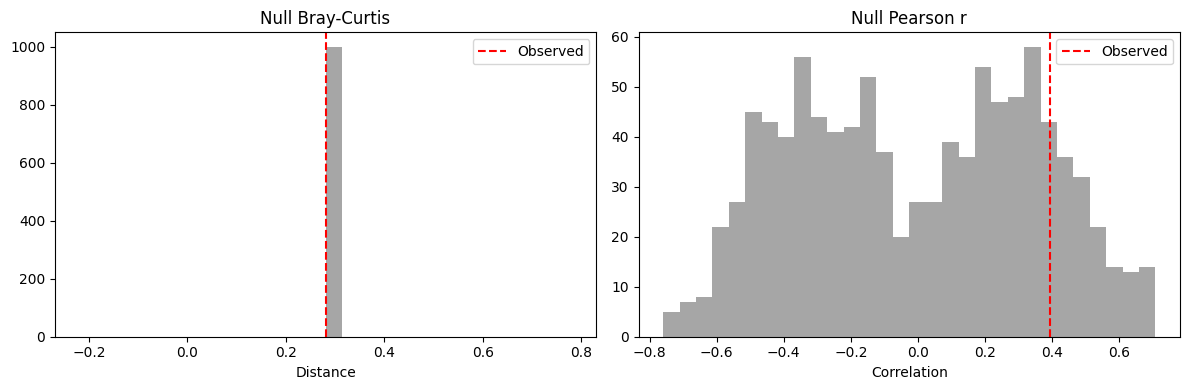

In [196]:
# Aggregate live data 2008+
live_opc = (
    census_long
    .query("year >= 2008")
    .groupby("species")["count"].sum()
)
live_opc_rel = to_relative_abundance(live_opc)

# Aggregate bones 2008+
bone_opc = (
    bones_long
    .query("death_year_estimate >= 2008")
    .groupby("species")["count"].sum()
)
bone_opc_rel = to_relative_abundance(bone_opc)

live_aligned, bone_aligned = align_vectors(live_opc_rel, bone_opc_rel)

bc_parts = bray_curtis_partition(live_aligned, bone_aligned)
bc_distance = bc_parts["bray_curtis"]
turnover = bc_parts["turnover"]
nestedness = bc_parts["nestedness"]
pear_corr, spear_corr = composition_correlation(live_aligned, bone_aligned)

print(f"Bray-Curtis distance (OPC 2008+): {bc_distance:.3f}")
print(f"  Turnover (balanced variation): {turnover:.3f}")
print(f"  Nestedness (abundance gradient): {nestedness:.3f}")
print(f"Pearson r: {pear_corr:.3f}; Spearman rho: {spear_corr:.3f}")

opc_partition = {
    "comparison": "OPC 2008+",
    "bray_curtis": bc_distance,
    "turnover": turnover,
    "nestedness": nestedness,
}

# Null models
bc_null = permutation_null(
    live_aligned,
    bone_aligned,
    lambda v1, v2: beta_diversity("braycurtis", np.vstack([v1, v2]), ids=["live", "bone"])[0, 1],
    n=999,
    random_state=CONFIG["random_state"],
)
pear_null = permutation_null(
    live_aligned,
    bone_aligned,
    lambda v1, v2: pearsonr(*align_vectors(v1, v2)).statistic,
    n=999,
    random_state=CONFIG["random_state"],
)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(bc_null, bins=30, color="grey", alpha=0.7)
axes[0].axvline(bc_distance, color="red", linestyle="--", label="Observed")
axes[0].set_title("Null Bray-Curtis")
axes[0].set_xlabel("Distance")
axes[0].legend()

axes[1].hist(pear_null, bins=30, color="grey", alpha=0.7)
axes[1].axvline(pear_corr, color="red", linestyle="--", label="Observed")
axes[1].set_title("Null Pearson r")
axes[1].set_xlabel("Correlation")
axes[1].legend()
plt.tight_layout()
plt.show()


## Q1 - Bone vs living community (East vs West)

In [197]:
sector_summary = []
for sector in ["E", "W"]:
    live_sector = (
        census_long.query("sector == @sector")
        .groupby("species")["count"].sum()
    )
    bone_sector = (
        bones_long.query("sector == @sector")
        .groupby("species")["count"].sum()
    )
    live_rel = to_relative_abundance(live_sector)
    bone_rel = to_relative_abundance(bone_sector)
    live_align, bone_align = align_vectors(live_rel, bone_rel)
    bc_parts = bray_curtis_partition(live_align, bone_align)
    pear, spear = composition_correlation(live_align, bone_align)
    sector_summary.append({
        "sector": sector,
        "bray_curtis": bc_parts["bray_curtis"],
        "turnover": bc_parts["turnover"],
        "nestedness": bc_parts["nestedness"],
        "pearson": pear,
        "spearman": spear,
    })

summary_df = pd.DataFrame(sector_summary)
summary_df


,sector,bray_curtis,turnover,nestedness,pearson,spearman
0,E,0.300240,0.220138,0.080102,0.300433,0.083333
1,W,0.326251,0.308302,0.017949,0.444246,-0.025105


In [198]:
# Cross comparisons
results = []
for bone_sector in ["E", "W"]:
    bone_comp = to_relative_abundance(
        bones_long.query("sector == @bone_sector").groupby("species")["count"].sum()
    )
    for live_sector in ["E", "W"]:
        live_comp = to_relative_abundance(
            census_long.query("sector == @live_sector").groupby("species")["count"].sum()
        )
        live_align, bone_align = align_vectors(live_comp, bone_comp)
        bc_parts = bray_curtis_partition(live_align, bone_align)
        pear, spear = composition_correlation(live_align, bone_align)
        results.append({
            "bone_sector": bone_sector,
            "live_sector": live_sector,
            "bray_curtis": bc_parts["bray_curtis"],
            "turnover": bc_parts["turnover"],
            "nestedness": bc_parts["nestedness"],
            "pearson": pear,
            "spearman": spear,
        })

cross_sector = pd.DataFrame(results)
cross_sector


,bone_sector,live_sector,bray_curtis,turnover,nestedness,pearson,spearman
0,E,E,0.300240,0.220138,0.080102,0.300433,0.083333
1,E,W,0.303829,0.255329,0.048499,0.391494,0.016667
2,W,E,0.335013,0.321228,0.013785,0.276125,-0.200839
3,W,W,0.326251,0.308302,0.017949,0.444246,-0.025105


## Q2 - Temporal change in aerial community (pre vs post 2007)

In [200]:
post_year = CONFIG["post_fence_year"]

census_long["period"] = np.where(census_long["year"] < post_year, "pre", "post")

permanova_results = []
period_distances = []
for sector in ["E", "W"]:
    subset = census_long.query("sector == @sector")
    matrix_counts, matrix_rel = make_species_matrix(
        subset, sample_cols=["year"], species_col="species", count_col="count", normalize=True
    )
    metadata = (
        subset.drop_duplicates(subset=["year"])
        .assign(sample_id=lambda d: d["year"].astype(str))
        .set_index("sample_id")[
            ["year", "sector", "period"]
        ]
    )
    metadata = metadata.loc[matrix_rel.index]

    perm = permanova_on_matrix(matrix_rel, metadata, factor_col="period")
    perm = perm.to_series() if hasattr(perm, "to_series") else perm
    pseudo_f = perm.get("test statistic", np.nan)
    p_value = perm.get("p-value", np.nan)
    df_between = perm.get("df", np.nan)
    df_total = (perm.get("sample size") - 1) if hasattr(perm, "index") and "sample size" in perm.index else np.nan
    r2 = np.nan
    if pd.notna(df_between) and pd.notna(df_total) and df_total > 0:
        df_within = max(df_total - df_between, 0)
        denom = (pseudo_f * df_between + df_within)
        r2 = (pseudo_f * df_between) / denom if denom != 0 else np.nan

    permanova_results.append(
        {
            "sector": sector,
            "pseudo_f": pseudo_f,
            "p_value": p_value,
            "r2": r2,
        }
    )

    bc_parts = bray_curtis_partition_between_groups(matrix_rel, metadata["period"])
    period_distances.append({
        "sector": sector,
        "bray_curtis_pre_post": bc_parts["bray_curtis"],
        "turnover_pre_post": bc_parts["turnover"],
        "nestedness_pre_post": bc_parts["nestedness"],
    })

permanova_df = pd.DataFrame(permanova_results)
period_distance_df = pd.DataFrame(period_distances)

permanova_df, period_distance_df


(  sector  pseudo_f  p_value  r2
 0      E  3.018315    0.015 NaN
 1      W  9.963856    0.007 NaN,
   sector  bray_curtis_pre_post  turnover_pre_post  nestedness_pre_post
 0      E              0.124268           0.124268         5.551115e-17
 1      W              0.204453           0.204453         5.551115e-17)

## Q2 - Temporal change in bones and change tracking

In [201]:
bones_long["period"] = np.where(bones_long["death_year_estimate"] < post_year, "pre", "post")

def change_vector(df: pd.DataFrame, sector: str, value_col: str, period_col: str = "period") -> pd.Series:
    """Return post-pre change in relative abundance for a sector."""
    subset = df.query("sector == @sector")
    pre = to_relative_abundance(subset.query("%s == 'pre'" % period_col).groupby("species")[value_col].sum())
    post = to_relative_abundance(subset.query("%s == 'post'" % period_col).groupby("species")[value_col].sum())
    pre, post = align_vectors(pre, post)
    return post - pre

change_results = []
delta_store = {}
for sector in ["E", "W"]:
    delta_live = change_vector(census_long, sector, "count", period_col="period")
    delta_bone = change_vector(bones_long, sector, "count", period_col="period")
    delta_live, delta_bone = align_vectors(delta_live, delta_bone)
    pear, spear = composition_correlation(delta_live, delta_bone)

    live_rel = make_species_matrix(census_long.query("sector == @sector"), ["period"], "species", "count", normalize=True)[1]
    bone_rel = make_species_matrix(bones_long.query("sector == @sector"), ["period"], "species", "count", normalize=True)[1]
    live_parts = bray_curtis_partition_between_groups(live_rel, live_rel.index.to_series())
    bone_parts = bray_curtis_partition_between_groups(bone_rel, bone_rel.index.to_series())

    delta_store[sector] = (delta_live, delta_bone)
    change_results.append({
        "sector": sector,
        "delta_pearson": pear,
        "delta_spearman": spear,
        "live_pre_post_bc": live_parts["bray_curtis"],
        "live_pre_post_turnover": live_parts["turnover"],
        "live_pre_post_nestedness": live_parts["nestedness"],
        "bone_pre_post_bc": bone_parts["bray_curtis"],
        "bone_pre_post_turnover": bone_parts["turnover"],
        "bone_pre_post_nestedness": bone_parts["nestedness"],
    })

change_df = pd.DataFrame(change_results)
change_df


,sector,delta_pearson,delta_spearman,live_pre_post_bc,live_pre_post_turnover,live_pre_post_nestedness,bone_pre_post_bc,bone_pre_post_turnover,bone_pre_post_nestedness
0,E,0.245777,0.133333,0.123518,0.123518,5.551115e-17,0.330205,0.330205,1.110223e-16
1,W,0.871954,0.800000,0.206209,0.206209,1.110223e-16,0.325073,0.325073,2.220446e-16


## Species drivers of Bray-Curtis change (SIMPER-style)

SIMPER-style contributions decompose the Bray-Curtis distance into species-level effects, clarifying whether pre/post contrasts hinge on a few dominant taxa or broad community shifts.

,dataset,sector,rank,species,share_of_bray,cumulative_share,delta,pre_abundance,post_abundance,pre_abundance_raw,post_abundance_raw
0,Aerial,E,1,Ceratotherium simum simum,0.165398,0.165398,0.040859,0.000000,0.040859,0.000000e+00,1.564982e+20
1,Aerial,W,1,Papio anubis,0.133718,0.133718,0.055148,0.000000,0.055148,0.000000e+00,3.585234e+30
2,Bone,E,1,Equus burchellii,0.235046,0.235046,-0.155227,0.384189,0.228962,2.341011e+09,1.828915e+12
3,Bone,W,1,Bos taurus indicus,0.186567,0.186567,-0.121296,0.121296,0.000000,8.000000e+00,0.000000e+00
4,Bone,W,2,Bovidae (medium),0.143970,0.330537,0.093601,0.060648,0.154249,2.000000e+00,1.990656e+06
5,Bone,E,2,Syncerus caffer,0.165372,0.400418,0.109213,0.000000,0.109213,0.000000e+00,4.915200e+05
6,Aerial,W,2,Diceros bicornis,0.106664,0.240382,0.043990,0.000000,0.043990,0.000000e+00,2.050460e+24
7,Aerial,E,2,Giraffa camelopardalis,0.126920,0.292319,-0.031354,0.075470,0.044116,8.466000e+03,6.732911e+21
8,Aerial,E,3,Kobus ellipsiprymnus,0.082793,0.375111,-0.020453,0.078790,0.058337,1.299200e+04,9.149765e+28
9,Aerial,W,3,Phacochoerus africanus,0.093581,0.333963,0.038595,0.024274,0.062868,1.200000e+01,7.488730e+34


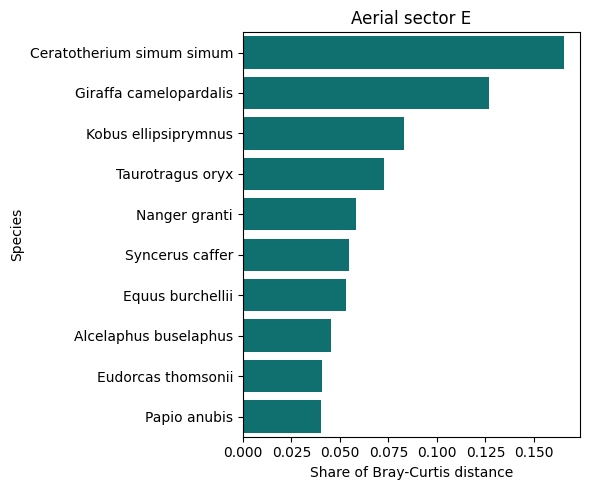

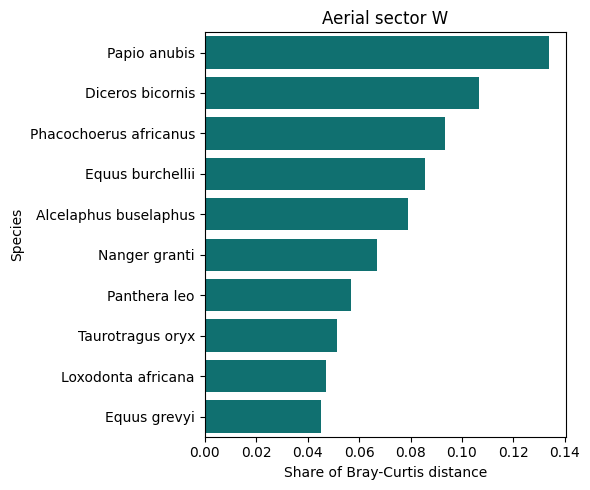

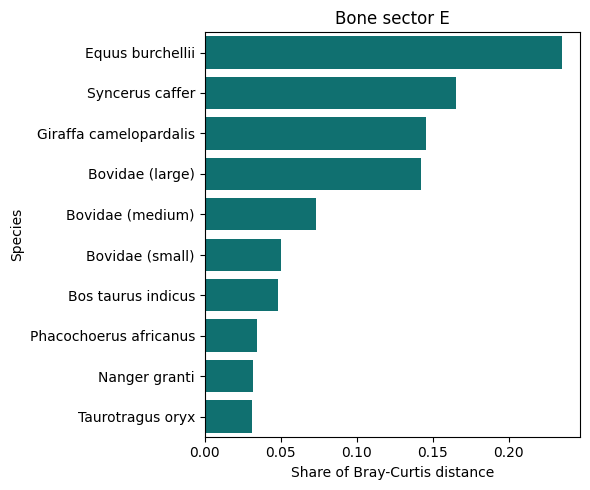

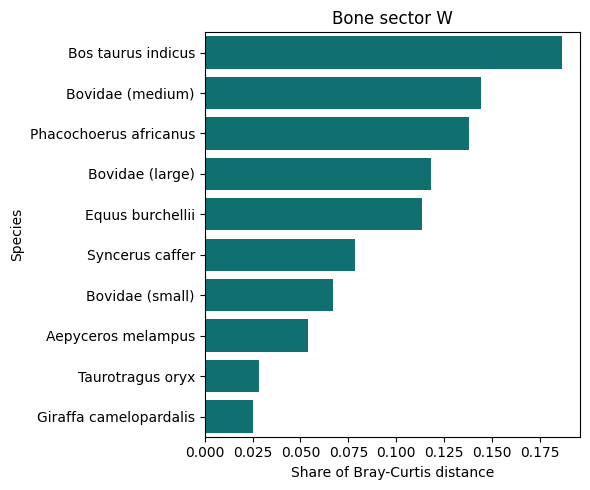

In [203]:
# SIMPER contributions for pre/post contrasts

census_long_raw["period"] = np.where(census_long_raw["year"] < post_year, "pre", "post")
bones_long_raw["period"] = np.where(bones_long_raw["death_year_estimate"] < post_year, "pre", "post")

def simper_by_dataset(df: pd.DataFrame, dataset_label: str, period_col: str = "period", value_col: str = "count") -> pd.DataFrame:
    results = []
    for sector in sorted(df["sector"].dropna().unique()):
        subset = df[df["sector"] == sector]
        pre_counts = subset[subset[period_col] == "pre"].groupby("species")[value_col].sum()
        post_counts = subset[subset[period_col] == "post"].groupby("species")[value_col].sum()
        if pre_counts.sum() == 0 and post_counts.sum() == 0:
            continue
        pre_raw_est = inverse_log2_plus1_anderson(pre_counts)
        post_raw_est = inverse_log2_plus1_anderson(post_counts)
        pre_rel = to_relative_abundance(pre_counts)
        post_rel = to_relative_abundance(post_counts)
        contrib = simper_contributions(pre_rel, post_rel)
        if contrib.empty:
            continue
        contrib["pre_abundance_raw"] = contrib["species"].map(pre_raw_est).fillna(0)
        contrib["post_abundance_raw"] = contrib["species"].map(post_raw_est).fillna(0)
        contrib.insert(0, "sector", sector)
        contrib.insert(0, "dataset", dataset_label)
        results.append(contrib)
    if not results:
        return pd.DataFrame(columns=[
            "dataset",
            "sector",
            "rank",
            "species",
            "share_of_bray",
            "cumulative_share",
            "delta",
            "pre_abundance",
            "post_abundance",
            "pre_abundance_raw",
            "post_abundance_raw",
        ])
    return pd.concat(results, ignore_index=True)

census_simper = simper_by_dataset(census_long, "Aerial")
bone_simper = simper_by_dataset(bones_long, "Bone")
simper_all = pd.concat([census_simper, bone_simper], ignore_index=True)

if simper_all.empty:
    print("Not enough data to compute SIMPER contributions.")
else:
    simper_top = (
        simper_all
        .sort_values("rank")
        .groupby(["dataset", "sector"], group_keys=False)
        .head(10)
        .reset_index(drop=True)
    )
    simper_top_table = simper_top.copy()
    display(
        simper_top[[
            "dataset",
            "sector",
            "rank",
            "species",
            "share_of_bray",
            "cumulative_share",
            "delta",
            "pre_abundance",
            "post_abundance",
            "pre_abundance_raw",
            "post_abundance_raw",
        ]]
    )

    for (dataset, sector), subset in simper_top.groupby(["dataset", "sector"]):
        subset = subset.sort_values("share_of_bray", ascending=False)
        plt.figure(figsize=(6, 5))
        sns.barplot(
            data=subset,
            x="share_of_bray",
            y="species",
            color="teal",
        )
        plt.title(f"{dataset} sector {sector}")
        plt.xlabel("Share of Bray-Curtis distance")
        plt.ylabel("Species")
        plt.tight_layout()
        plt.show()


## Bray-Curtis partition insights

Turnover captures species replacements (gains/losses) while nestedness captures abundance gradients when compositions retain similar species sets. Partitioning the Bray-Curtis distances clarifies whether contrasts are driven by wholesale species turnover or by nested shifts in abundance structure.

## Population trajectories for key species

Top SIMPER contributors can mask whether shifts reflect gradual trends or sharp breaks. Tracking their raw abundances through time highlights which taxa boomed, crashed, or steadily emerged after the 2007 fence removal.

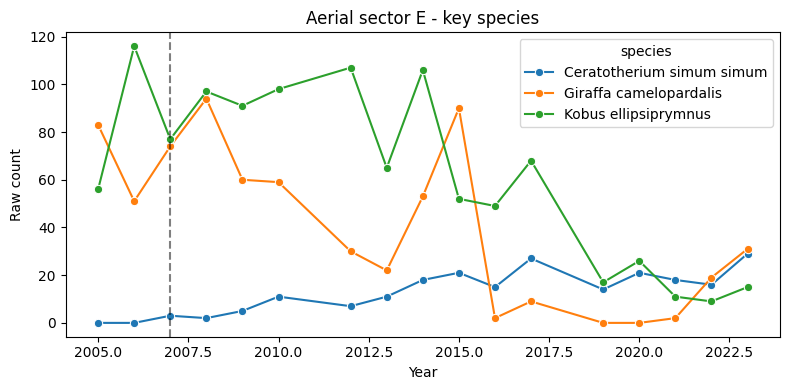

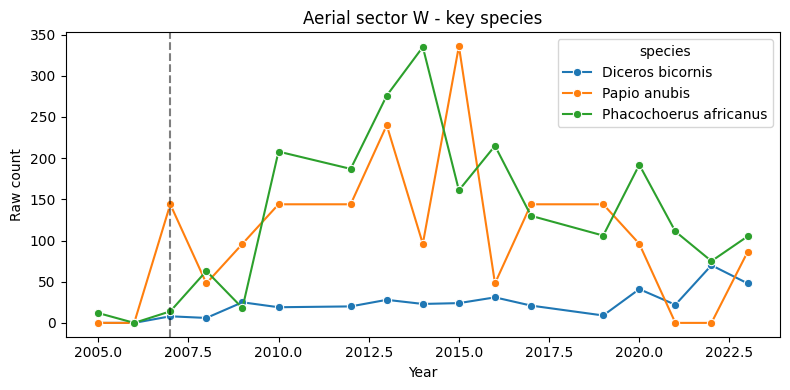

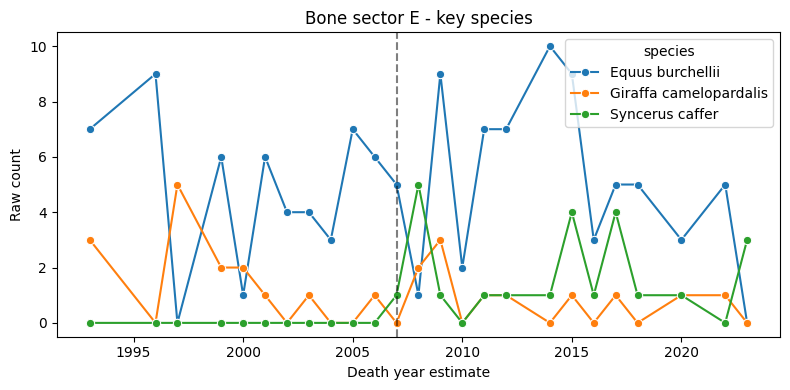

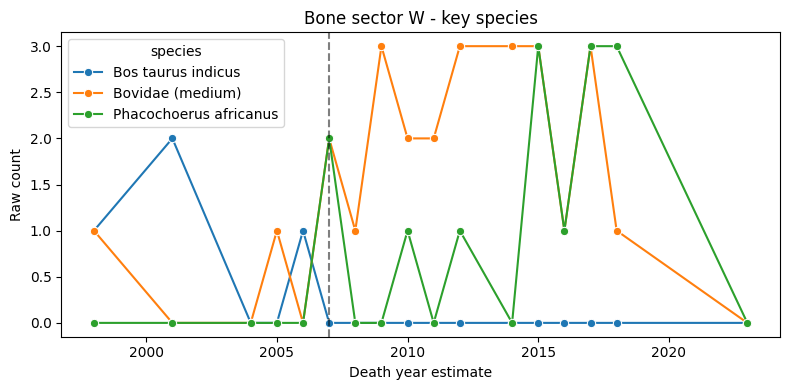

In [204]:
# Population trajectories for SIMPER-prioritised species
if "simper_top_table" not in globals() or simper_top_table.empty:
    print("SIMPER results not available; run the previous cell to compute contributions.")
else:
    def top_species_by_group(df: pd.DataFrame, n: int = 3) -> pd.DataFrame:
        rows = []
        for (dataset, sector), subset in df.groupby(["dataset", "sector"]):
            top = subset.sort_values("share_of_bray", ascending=False).head(n)
            for species in top["species"]:
                rows.append({"dataset": dataset, "sector": sector, "species": species})
        return pd.DataFrame(rows)

    top_species = top_species_by_group(simper_top_table, n=3)
    dataset_cfg = {
        "Aerial": {"df": census_long_raw.copy(), "time_col": "year", "time_label": "Year"},
        "Bone": {"df": bones_long_raw.copy(), "time_col": "death_year_estimate", "time_label": "Death year estimate"},
    }

    for (dataset, sector), subset in top_species.groupby(["dataset", "sector"]):
        cfg = dataset_cfg.get(dataset)
        if cfg is None:
            continue
        df = cfg["df"]
        species_list = subset["species"].unique()
        sector_df = df[(df["sector"] == sector) & (df["species"].isin(species_list))]
        if sector_df.empty:
            print(f"No raw records for {dataset} sector {sector} top species")
            continue
        grouped = (sector_df
                   .groupby([cfg["time_col"], "species"])['count'].sum()
                   .reset_index())
        if grouped.empty:
            print(f"No counts to plot for {dataset} sector {sector}")
            continue
        plt.figure(figsize=(8, 4))
        sns.lineplot(data=grouped, x=cfg["time_col"], y="count", hue="species", marker="o")
        plt.axvline(post_year, color="black", linestyle="--", alpha=0.5)
        plt.title(f"{dataset} sector {sector} - key species")
        plt.xlabel(cfg["time_label"])
        plt.ylabel("Raw count")
        plt.tight_layout()
        plt.show()


In [205]:
# Summaries of turnover vs nestedness contributions across comparisons
partition_rows = []
partition_rows.append(opc_partition)

sector_partitions = summary_df.assign(
    comparison=lambda d: "Sector match ? " + d["sector"]
)[["comparison", "bray_curtis", "turnover", "nestedness"]]
partition_rows.extend(sector_partitions.to_dict("records"))

cross_partitions = cross_sector.assign(
    comparison=lambda d: f"Bone {d['bone_sector']} vs live {d['live_sector']}"
)[["comparison", "bray_curtis", "turnover", "nestedness"]]
partition_rows.extend(cross_partitions.to_dict("records"))

period_partitions = period_distance_df.assign(
    comparison=lambda d: "Aerial pre vs post ? " + d["sector"],
    bray_curtis=lambda d: d["bray_curtis_pre_post"],
    turnover=lambda d: d["turnover_pre_post"],
    nestedness=lambda d: d["nestedness_pre_post"],
)[["comparison", "bray_curtis", "turnover", "nestedness"]]
partition_rows.extend(period_partitions.to_dict("records"))

live_partitions = change_df.assign(
    comparison=lambda d: "Live pre vs post ? sector " + d["sector"],
    bray_curtis=lambda d: d["live_pre_post_bc"],
    turnover=lambda d: d["live_pre_post_turnover"],
    nestedness=lambda d: d["live_pre_post_nestedness"],
)[["comparison", "bray_curtis", "turnover", "nestedness"]]
partition_rows.extend(live_partitions.to_dict("records"))

bone_partitions = change_df.assign(
    comparison=lambda d: "Bone pre vs post ? sector " + d["sector"],
    bray_curtis=lambda d: d["bone_pre_post_bc"],
    turnover=lambda d: d["bone_pre_post_turnover"],
    nestedness=lambda d: d["bone_pre_post_nestedness"],
)[["comparison", "bray_curtis", "turnover", "nestedness"]]
partition_rows.extend(bone_partitions.to_dict("records"))

beta_partition_summary = pd.DataFrame(partition_rows)
beta_partition_summary["turnover_share"] = np.where(
    beta_partition_summary["bray_curtis"] > 0,
    beta_partition_summary["turnover"] / beta_partition_summary["bray_curtis"],
    np.nan,
)
beta_partition_summary["nestedness_share"] = np.where(
    beta_partition_summary["bray_curtis"] > 0,
    beta_partition_summary["nestedness"] / beta_partition_summary["bray_curtis"],
    np.nan,
)

beta_partition_summary


,comparison,bray_curtis,turnover,nestedness,turnover_share,nestedness_share
0,OPC 2008+,0.280564,0.255051,2.551311e-02,0.909065,9.093512e-02
1,Sector match ? E,0.300240,0.220138,8.010225e-02,0.733206,2.667943e-01
2,Sector match ? W,0.326251,0.308302,1.794906e-02,0.944984,5.501608e-02
3,Bone 0 E\n1 E\n2 W\n3 W\nName: bon...,0.300240,0.220138,8.010225e-02,0.733206,2.667943e-01
4,Bone 0 E\n1 E\n2 W\n3 W\nName: bon...,0.303829,0.255329,4.849946e-02,0.840372,1.596276e-01
5,Bone 0 E\n1 E\n2 W\n3 W\nName: bon...,0.335013,0.321228,1.378484e-02,0.958853,4.114719e-02
6,Bone 0 E\n1 E\n2 W\n3 W\nName: bon...,0.326251,0.308302,1.794906e-02,0.944984,5.501608e-02
7,Aerial pre vs post ? E,0.124268,0.124268,5.551115e-17,1.000000,4.467048e-16
8,Aerial pre vs post ? W,0.204453,0.204453,5.551115e-17,1.000000,2.715112e-16
9,Live pre vs post ? sector E,0.123518,0.123518,5.551115e-17,1.000000,4.494181e-16


## Species richness & identity shifts

Richness (S) provides a quick diagnostic of whether communities gained or lost taxa, while species transition tables expose which identities drove turnover (losses vs colonisations vs persistent species).

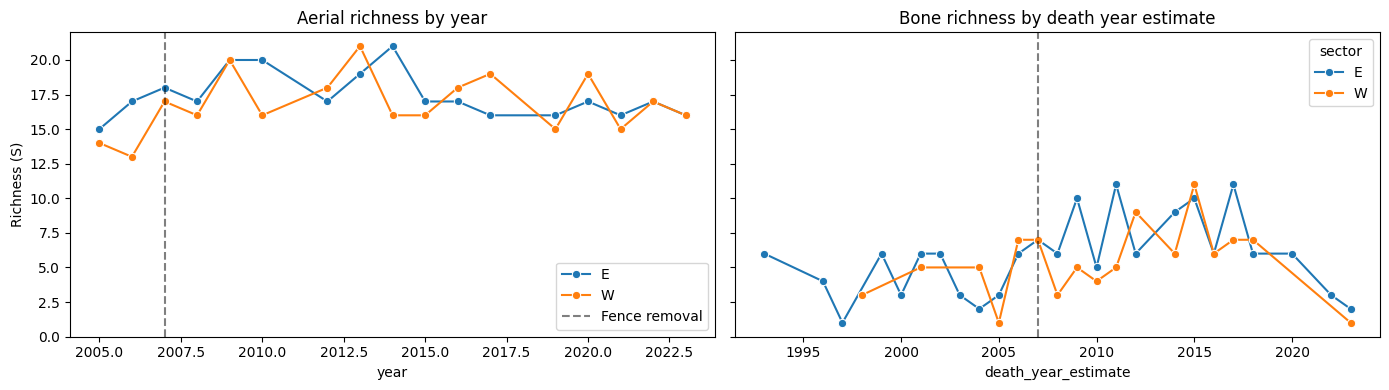

Aerial richness by period and sector:


period,post,pre
sector,,
E,24,17
W,24,16


Bone richness by period and sector:


period,post,pre
sector,,
E,13,12
W,12,11


In [207]:
# Species richness trajectories by sector and dataset
def compute_richness(df, group_cols, count_col="count") -> pd.DataFrame:
    subset = df[df[count_col] > 0].copy()
    return (
        subset.groupby(group_cols)["species"]
        .nunique()
        .reset_index(name="richness")
        .sort_values(group_cols)
    )

census_long_raw["period"] = np.where(census_long_raw["year"] < post_year, "pre", "post")
bones_long_raw["period"] = np.where(bones_long_raw["death_year_estimate"] < post_year, "pre", "post")

census_richness_year = compute_richness(census_long_raw, ["sector", "year"])
bone_richness_year = compute_richness(bones_long_raw, ["sector", "death_year_estimate"])

census_richness_period = compute_richness(census_long_raw, ["sector", "period"])
bone_richness_period = compute_richness(bones_long_raw, ["sector", "period"])

fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)
sns.lineplot(
    data=census_richness_year,
    x="year",
    y="richness",
    hue="sector",
    marker="o",
    ax=axes[0],
)
axes[0].axvline(post_year, color="black", linestyle="--", alpha=0.5, label="Fence removal")
axes[0].set_title("Aerial richness by year")
axes[0].set_ylabel("Richness (S)")
axes[0].legend(loc="best")

if not bone_richness_year.empty:
    sns.lineplot(
        data=bone_richness_year,
        x="death_year_estimate",
        y="richness",
        hue="sector",
        marker="o",
        ax=axes[1],
    )
    axes[1].axvline(post_year, color="black", linestyle="--", alpha=0.5)
    axes[1].set_title("Bone richness by death year estimate")
else:
    axes[1].text(0.5, 0.5, "No bone year data", ha="center", va="center")
    axes[1].set_axis_off()
axes[1].set_ylabel("Richness (S)")
plt.tight_layout()
plt.show()

print("Aerial richness by period and sector:")
display(census_richness_period.pivot(index="sector", columns="period", values="richness"))
print("Bone richness by period and sector:")
display(bone_richness_period.pivot(index="sector", columns="period", values="richness"))


In [208]:
# Species presence-absence transitions pre vs post
def build_transition_df(df, dataset_label, period_col):
    records = []
    sectors = sorted(df["sector"].dropna().unique())
    for sector in sectors:
        subset = df[df["sector"] == sector]
        pre_species = set(subset[subset[period_col] == "pre"]["species"])
        post_species = set(subset[subset[period_col] == "post"]["species"])
        for species in sorted(pre_species - post_species):
            records.append({
                "dataset": dataset_label,
                "sector": sector,
                "status": "loss",
                "species": species,
            })
        for species in sorted(post_species - pre_species):
            records.append({
                "dataset": dataset_label,
                "sector": sector,
                "status": "gain",
                "species": species,
            })
        for species in sorted(pre_species & post_species):
            records.append({
                "dataset": dataset_label,
                "sector": sector,
                "status": "persistent",
                "species": species,
            })
    return pd.DataFrame(records)

census_transitions = build_transition_df(census_long_raw, "Aerial", "period")
bone_transitions = build_transition_df(bones_long_raw, "Bone", "period")
transition_df = pd.concat([census_transitions, bone_transitions], ignore_index=True)

transition_counts = (
    transition_df.groupby(["dataset", "sector", "status"])
    .size()
    .reset_index(name="n_species")
    .pivot_table(index=["dataset", "sector"], columns="status", values="n_species", fill_value=0)
    .reset_index()
)
print("Species turnover counts (loss vs gain vs persistent):")
display(transition_counts)

max_listed = 20
def summarise_species(vals):
    species_list = list(vals)
    if not species_list:
        return "-"
    preview = ", ".join(species_list[:max_listed])
    if len(species_list) > max_listed:
        preview += ", ..."
    return preview

species_lists = (
    transition_df.groupby(["dataset", "sector", "status"])["species"]
    .apply(summarise_species)
    .unstack("status")
    .fillna("-")
    .reset_index()
)
print("Species identities driving transitions (first 20 per cell):")
display(species_lists)


Species turnover counts (loss vs gain vs persistent):


status,dataset,sector,persistent
0,Aerial,E,24.0
1,Aerial,W,24.0
2,Bone,E,13.0
3,Bone,W,13.0


Species identities driving transitions (first 20 per cell):


status,dataset,sector,persistent
0,Aerial,E,"Aepyceros melampus, Alcelaphus buselaphus, Can..."
1,Aerial,W,"Aepyceros melampus, Alcelaphus buselaphus, Can..."
2,Bone,E,"Aepyceros melampus, Bos taurus indicus, Bovida..."
3,Bone,W,"Aepyceros melampus, Bos taurus indicus, Bovida..."


## Rank-abundance changes

Rank-abundance curves highlight structural change in dominance and evenness independent of species identity. Comparing pre- and post-2007 curves by sector reveals whether dominant taxa became more or less dominant and whether evenness increased or decreased.

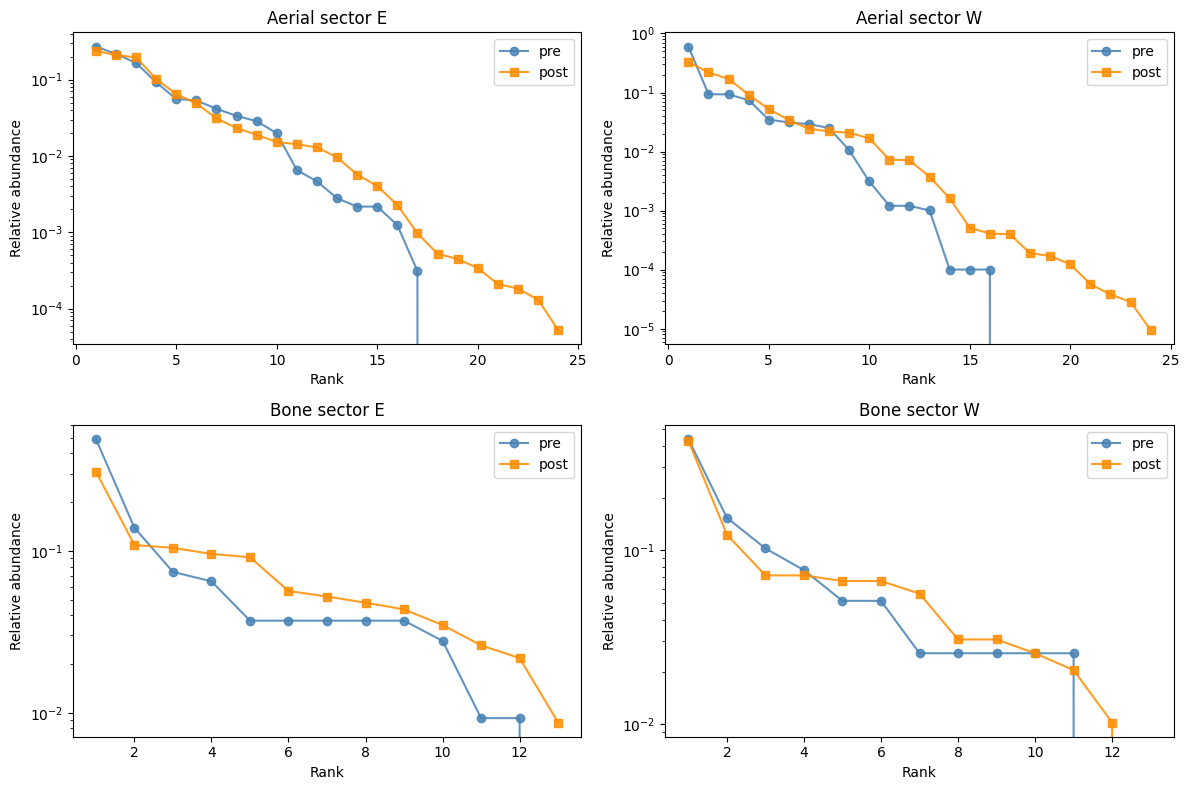

period,dataset,sector,rank,post,pre
0,Aerial,E,1,Aepyceros melampus,Syncerus caffer
1,Aerial,E,2,Syncerus caffer,Equus burchellii
2,Aerial,E,3,Equus burchellii,Aepyceros melampus
3,Aerial,E,4,Eudorcas thomsonii,Nanger granti
4,Aerial,E,5,Nanger granti,Papio anubis
5,Aerial,W,1,Equus burchellii,Equus burchellii
6,Aerial,W,2,Aepyceros melampus,Nanger granti
7,Aerial,W,3,Syncerus caffer,Aepyceros melampus
8,Aerial,W,4,Eudorcas thomsonii,Eudorcas thomsonii
9,Aerial,W,5,Nanger granti,Syncerus caffer


In [209]:
# Rank-abundance curves pre vs post for each sector and dataset
def make_rank_abundance(df, sector, period_col="period", value_col="count"):
    subset = df[df["sector"] == sector]
    records = []
    for period in ["pre", "post"]:
        period_df = subset[subset[period_col] == period]
        if period_df.empty:
            continue
        counts = period_df.groupby("species")[value_col].sum()
        rel = to_relative_abundance(counts)
        ranked = rel.sort_values(ascending=False).reset_index()
        ranked.columns = ["species", "relative_abundance"]
        ranked["relative_abundance"] = ranked["relative_abundance"].fillna(0)
        ranked["rank"] = ranked.index + 1
        ranked["period"] = period
        records.append(ranked)
    if not records:
        return pd.DataFrame(columns=["species", "relative_abundance", "rank", "period"])
    return pd.concat(records, ignore_index=True)

census_long_raw["period"] = np.where(census_long_raw["year"] < post_year, "pre", "post")
bones_long_raw["period"] = np.where(bones_long_raw["death_year_estimate"] < post_year, "pre", "post")

rank_configs = [
    ("Aerial", census_long_raw),
    ("Bone", bones_long_raw),
]

fig, axes = plt.subplots(len(rank_configs), 2, figsize=(12, 4 * len(rank_configs)), sharex=False, sharey=False)
axes = np.atleast_2d(axes)

for row, (label, dataset) in enumerate(rank_configs):
    for col, sector in enumerate(["E", "W"]):
        ax = axes[row, col]
        rank_df = make_rank_abundance(dataset, sector)
        if rank_df.empty:
            ax.text(0.5, 0.5, f"No data for sector {sector}", ha="center", va="center")
            ax.set_axis_off()
            continue
        for period, marker, color in [("pre", "o", "steelblue"), ("post", "s", "darkorange")]:
            subset = rank_df[rank_df["period"] == period]
            if subset.empty:
                continue
            ax.plot(
                subset["rank"],
                subset["relative_abundance"],
                label=period,
                marker=marker,
                linestyle="-",
                color=color,
                alpha=0.85,
            )
        ax.set_title(f"{label} sector {sector}")
        ax.set_xlabel("Rank")
        ax.set_ylabel("Relative abundance")
        ax.set_yscale("log")
        ax.legend()

plt.tight_layout()
plt.show()

# Table summarising top-ranked species pre vs post
top_n = 5
rank_tables = []
for label, dataset in rank_configs:
    for sector in ["E", "W"]:
        rank_df = make_rank_abundance(dataset, sector)
        if rank_df.empty:
            continue
        top = (
            rank_df[rank_df["rank"] <= top_n]
            .pivot_table(index="rank", columns="period", values="species", aggfunc="first")
            .reset_index()
        )
        top.insert(0, "sector", sector)
        top.insert(0, "dataset", label)
        rank_tables.append(top)

if rank_tables:
    rank_top_summary = pd.concat(rank_tables, ignore_index=True)
    display(rank_top_summary)
else:
    print("No rank-abundance data available to summarise.")


## Differential abundance (pre vs post 2007)

Non-parametric Mann?Whitney U tests highlight species whose abundances shifted after fence removal within each sector and dataset. Volcano plots emphasise the direction/magnitude of change, while bar charts list the strongest responders.

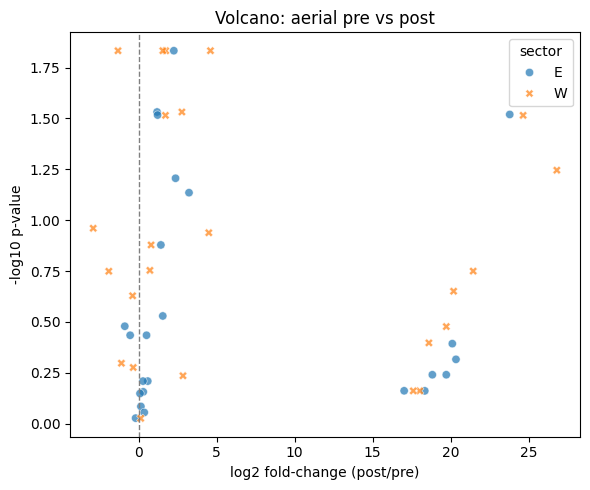

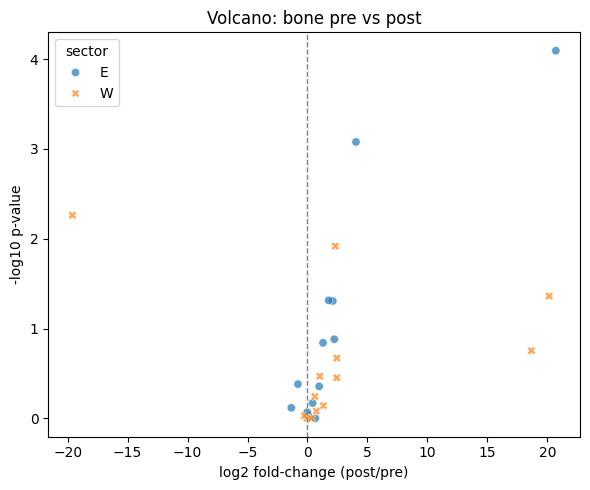

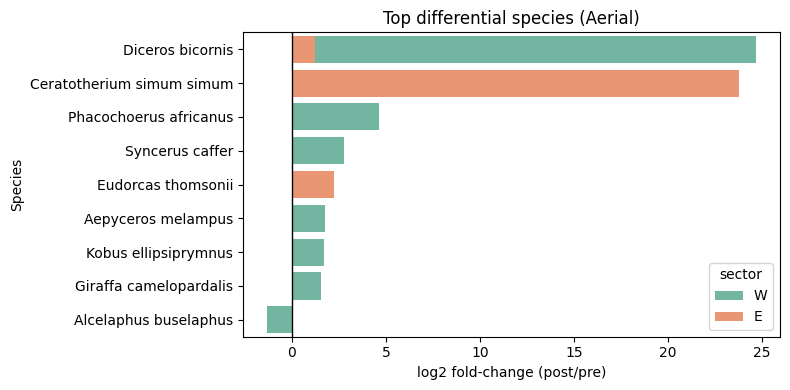

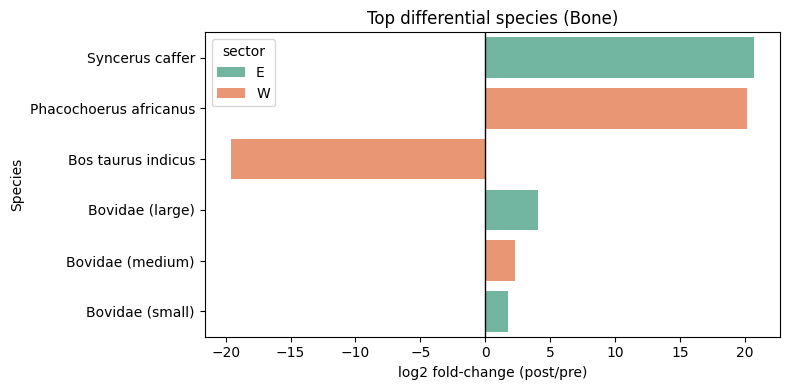

Differential abundance table (first rows)


,dataset,sector,species,log2_fc,p_value,mean_pre,mean_post,neg_log10_p
0,Aerial,E,Aepyceros melampus,1.187232,0.029412,267.0,608.000000,1.531479
1,Aerial,E,Alcelaphus buselaphus,2.371094,0.062247,7.5,38.800000,1.205882
2,Aerial,E,Canis mesomelas,20.112142,0.404315,0.0,1.133333,0.393280
3,Aerial,E,Ceratotherium simum simum,23.792862,0.030246,0.0,14.533333,1.519328
4,Aerial,E,Crocuta,20.346607,0.482799,0.0,1.333333,0.316234
5,Aerial,E,Diceros bicornis,1.220428,0.030450,10.5,24.466667,1.516412
6,Aerial,E,Equus,18.346610,0.689733,0.0,0.333333,0.161319
7,Aerial,E,Equus burchellii,0.511685,0.367647,350.0,499.000000,0.434569
8,Aerial,E,Equus grevyi,1.552541,0.295531,3.5,10.266667,0.529397
9,Aerial,E,Eudorcas thomsonii,2.260063,0.014706,54.0,258.666667,1.832509


In [211]:
# Mann?Whitney tests on pre vs post samples
from scipy.stats import mannwhitneyu

def prepare_period_counts(df, sample_col, value_col="count"):
    return (
        df.groupby(["sector", "period", "species", sample_col])[value_col]
        .sum()
        .reset_index()
    )

def mannwhitney_differential(df, dataset_label, sample_col, value_col="count", min_reps=2):
    results = []
    counts = prepare_period_counts(df, sample_col, value_col=value_col)
    for sector in sorted(counts["sector"].unique()):
        sector_df = counts[counts["sector"] == sector]
        for species, species_df in sector_df.groupby("species"):
            pre = species_df.loc[species_df["period"] == "pre", value_col].values
            post = species_df.loc[species_df["period"] == "post", value_col].values
            if len(pre) < min_reps or len(post) < min_reps:
                continue
            stat, p_value = mannwhitneyu(pre, post, alternative="two-sided")
            mean_pre = pre.mean()
            mean_post = post.mean()
            log2_fc = np.log2((mean_post + 1e-6) / (mean_pre + 1e-6))
            results.append({
                "dataset": dataset_label,
                "sector": sector,
                "species": species,
                "log2_fc": log2_fc,
                "p_value": p_value,
                "mean_pre": mean_pre,
                "mean_post": mean_post,
            })
    if not results:
        return pd.DataFrame(columns=["dataset", "sector", "species", "log2_fc", "p_value", "mean_pre", "mean_post"])
    res_df = pd.DataFrame(results)
    res_df["neg_log10_p"] = -np.log10(res_df["p_value"].replace(0, np.nextafter(0, 1)))
    return res_df

census_long_raw["period"] = np.where(census_long_raw["year"] < post_year, "pre", "post")
bones_long_raw["period"] = np.where(bones_long_raw["death_year_estimate"] < post_year, "pre", "post")

census_da = mannwhitney_differential(census_long_raw, "Aerial", sample_col="year")
bone_da = mannwhitney_differential(bones_long_raw, "Bone", sample_col="death_year_estimate")

def plot_volcano(da_df, title):
    if da_df.empty:
        print(f"No differential tests available for {title}.")
        return
    plt.figure(figsize=(6,5))
    sns.scatterplot(data=da_df, x="log2_fc", y="neg_log10_p", hue="sector", style="sector", alpha=0.7)
    plt.axvline(0, color="grey", linestyle="--", linewidth=1)
    plt.xlabel("log2 fold-change (post/pre)")
    plt.ylabel("-log10 p-value")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_volcano(census_da, "Volcano: aerial pre vs post")
plot_volcano(bone_da, "Volcano: bone pre vs post")

# Bar plots of strongest changers
def top_changes(da_df, n=10, p_thresh=0.05):
    if da_df.empty:
        return pd.DataFrame(columns=da_df.columns)
    filtered = da_df.copy()
    if "p_value" in filtered:
        filtered = filtered.sort_values("p_value")
    strongest = (
        filtered.loc[filtered["p_value"] <= p_thresh]
        .assign(abs_fc=lambda d: d["log2_fc"].abs())
        .sort_values("abs_fc", ascending=False)
        .head(n)
    )
    return strongest

census_top = top_changes(census_da)
bone_top = top_changes(bone_da)

for label, df_top in [("Aerial", census_top), ("Bone", bone_top)]:
    if df_top.empty:
        print(f"No significant changes found for {label} dataset at p<=0.05")
        continue
    plt.figure(figsize=(8,4))
    sns.barplot(
        data=df_top,
        x="log2_fc",
        y="species",
        hue="sector",
        dodge=False,
        palette="Set2"
    )
    plt.axvline(0, color="black", linewidth=1)
    plt.title(f"Top differential species ({label})")
    plt.xlabel("log2 fold-change (post/pre)")
    plt.ylabel("Species")
    plt.tight_layout()
    plt.show()

print("Differential abundance table (first rows)")
display(pd.concat([census_da, bone_da], ignore_index=True).head(40))

## Visualisations

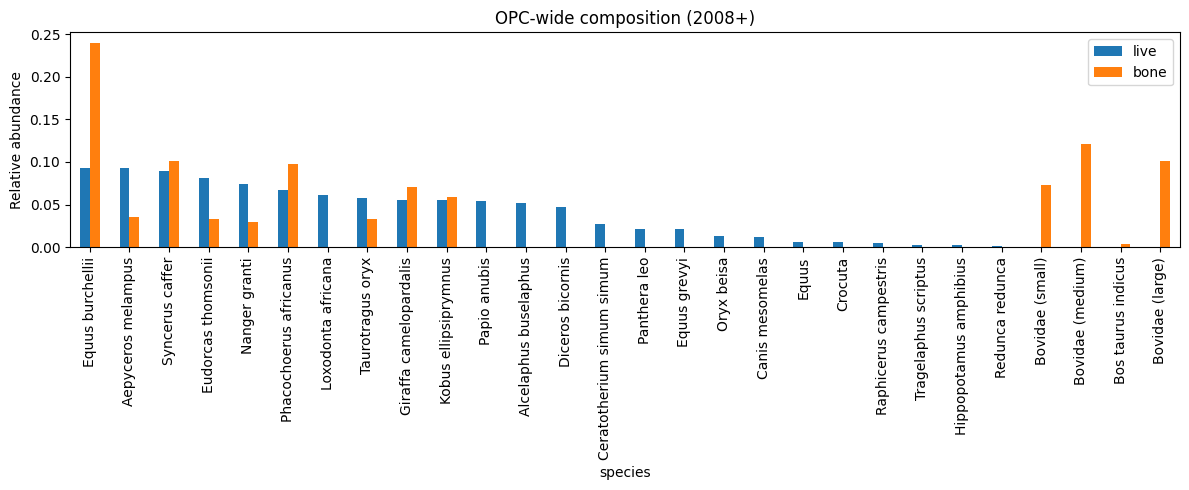

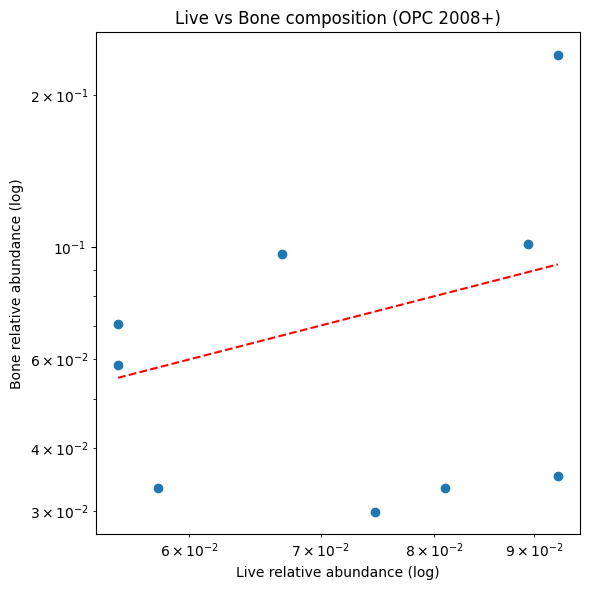

In [212]:
def plot_composition_bar(live_series: pd.Series, bone_series: pd.Series, title: str):
    live_df = live_series.rename("live").reset_index()
    bone_df = bone_series.rename("bone").reset_index()
    merged = pd.merge(live_df, bone_df, on="species", how="outer").fillna(0)
    merged = merged.set_index("species").sort_values("live", ascending=False)
    merged.plot(kind="bar", figsize=(12, 5))
    plt.ylabel("Relative abundance")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_composition_bar(live_opc_rel, bone_opc_rel, "OPC-wide composition (2008+)")

# Scatter live vs bone
plt.figure(figsize=(6,6))
plt.scatter(live_aligned + 1e-6, bone_aligned + 1e-6)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Live relative abundance (log)')
plt.ylabel('Bone relative abundance (log)')
plt.title('Live vs Bone composition (OPC 2008+)')
plt.plot([live_aligned.min(), live_aligned.max()], [live_aligned.min(), live_aligned.max()], 'r--')
plt.tight_layout()
plt.show()


/opt/conda/lib/python3.11/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:157: RuntimeWarning: EIGH: since no value for dimensions is specified, PCoA for all dimensions will be computed, which may result in long computation time if the original distance matrix is large.
  warn(
/opt/conda/lib/python3.11/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:275: RuntimeWarning: The result contains negative eigenvalues that are large in magnitude, which may suggest result inaccuracy. See Notes for details. The negative-most eigenvalue is -0.010430980413557223 whereas the largest positive one is 0.16519375820607482.
  warn(


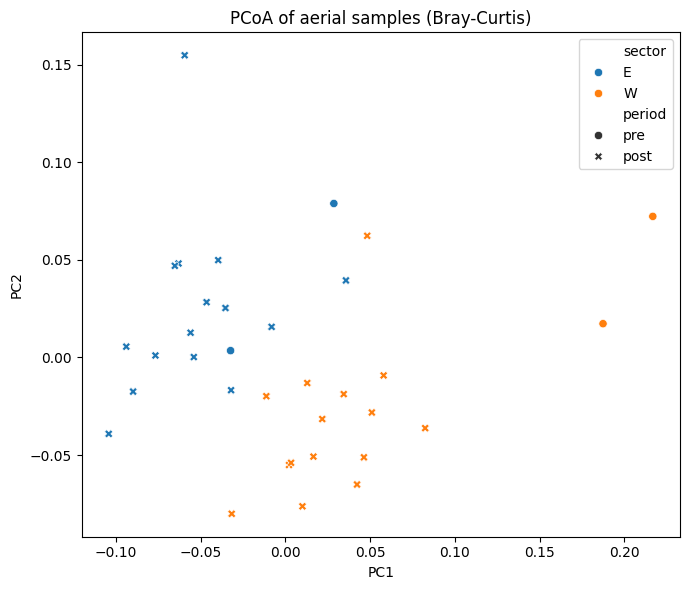

In [213]:
# PCoA on aerial data
aerial_matrix_counts, aerial_matrix_rel = make_species_matrix(
    census_long,
    sample_cols=["year", "sector"],
    species_col="species",
    count_col="count",
    normalize=True,
)
aerial_metadata = (
    census_long.drop_duplicates(subset=["year", "sector"])[["year", "sector", "period"]]
    .assign(sample_id=lambda d: d[["year", "sector"]].astype(str).agg("_".join, axis=1))
    .set_index("sample_id")
    .loc[aerial_matrix_rel.index]
)

dist = beta_diversity("braycurtis", aerial_matrix_rel.values, ids=aerial_matrix_rel.index)
pcoa_res = skbio.stats.ordination.pcoa(dist)
aerial_pcoa_df = pcoa_res.samples.iloc[:, :2].copy()
aerial_pcoa_df.columns = ["PC1", "PC2"]
aerial_pcoa_df = aerial_pcoa_df.join(aerial_metadata)

plt.figure(figsize=(7, 6))
sns.scatterplot(data=aerial_pcoa_df, x="PC1", y="PC2", hue="sector", style="period")
plt.title("PCoA of aerial samples (Bray-Curtis)")
plt.tight_layout()
plt.show()


## Community trajectories in ordination space

PCoA trajectories show how annual community snapshots shifted before and after the 2007 fence removal. By connecting yearly points within each sector, arrows visualise the direction and magnitude of community movement in multivariate space.

/opt/conda/lib/python3.11/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:157: RuntimeWarning: EIGH: since no value for dimensions is specified, PCoA for all dimensions will be computed, which may result in long computation time if the original distance matrix is large.
  warn(
/opt/conda/lib/python3.11/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:275: RuntimeWarning: The result contains negative eigenvalues that are large in magnitude, which may suggest result inaccuracy. See Notes for details. The negative-most eigenvalue is -0.010430980413557223 whereas the largest positive one is 0.16519375820607482.
  warn(
/opt/conda/lib/python3.11/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:157: RuntimeWarning: EIGH: since no value for dimensions is specified, PCoA for all dimensions will be computed, which may result in long computation time if the original distance matrix is large.
  warn(
/opt/conda/lib/python3.11/sit

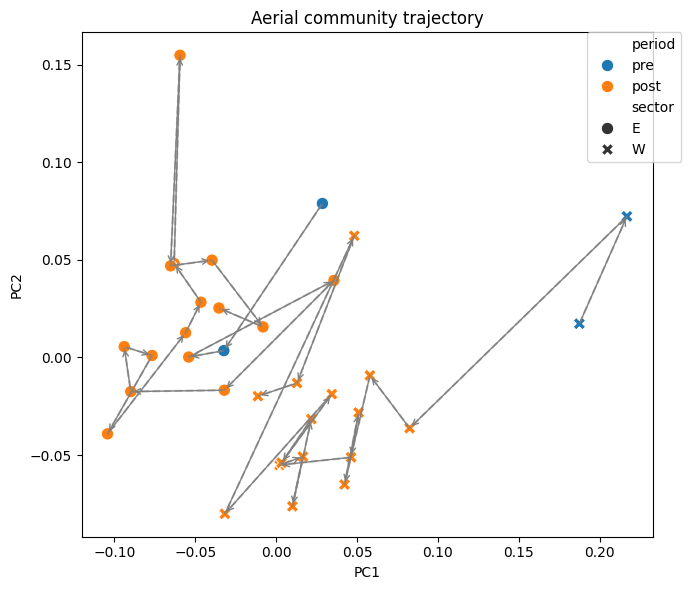

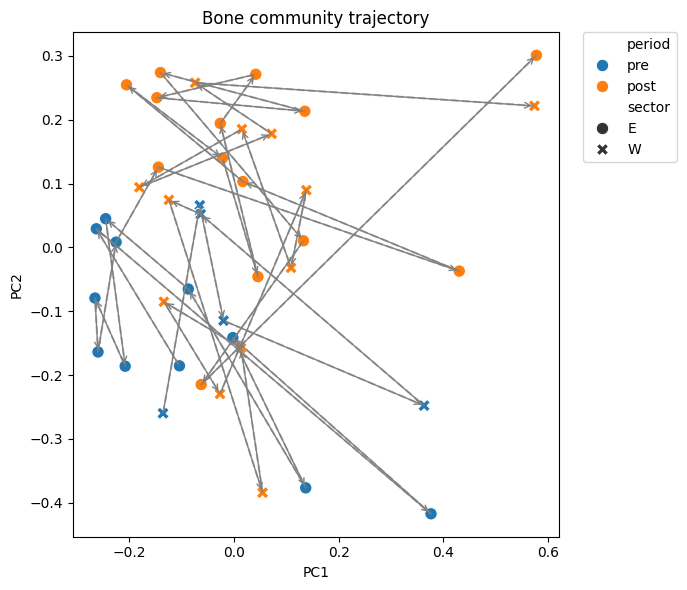

In [214]:
# PCoA trajectories with arrows
def compute_pcoa_coords(df, sample_col, label):
    matrix_counts, matrix_rel = make_species_matrix(
        df,
        sample_cols=[sample_col, "sector"],
        species_col="species",
        count_col="count",
        normalize=True,
    )
    metadata = (
        df.drop_duplicates(subset=[sample_col, "sector"])[[sample_col, "sector", "period"]]
        .assign(sample_id=lambda d: d[[sample_col, "sector"]].astype(str).agg("_".join, axis=1))
        .set_index("sample_id")
        .loc[matrix_rel.index]
    )
    dist = beta_diversity("braycurtis", matrix_rel.values, ids=matrix_rel.index)
    coords = skbio.stats.ordination.pcoa(dist).samples.iloc[:, :2].copy()
    coords.columns = ["PC1", "PC2"]
    coords = coords.join(metadata)
    coords["dataset"] = label
    return coords

def plot_trajectory(coords, order_col, title):
    if coords.empty:
        print(f"No samples available for {title}.")
        return
    coords = coords.sort_values(order_col)
    plt.figure(figsize=(7, 6))
    sns.scatterplot(
        data=coords,
        x="PC1",
        y="PC2",
        hue="period",
        style="sector",
        s=80,
    )
    for sector, sector_df in coords.groupby("sector"):
        sector_df = sector_df.sort_values(order_col)
        if len(sector_df) < 2:
            continue
        plt.plot(sector_df["PC1"], sector_df["PC2"], color="grey", linestyle="--", alpha=0.6)
        for i in range(len(sector_df) - 1):
            start = sector_df.iloc[i]
            end = sector_df.iloc[i + 1]
            plt.annotate(
                "",
                xy=(end["PC1"], end["PC2"]),
                xytext=(start["PC1"], start["PC2"]),
                arrowprops=dict(arrowstyle="->", color="grey", lw=1),
            )
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.tight_layout()
    plt.show()

pcoa_aerial = compute_pcoa_coords(census_long, "year", "Aerial")
pcoa_bone = compute_pcoa_coords(bones_long, "death_year_estimate", "Bone")

plot_trajectory(pcoa_aerial, order_col="year", title="Aerial community trajectory")
plot_trajectory(pcoa_bone, order_col="death_year_estimate", title="Bone community trajectory")


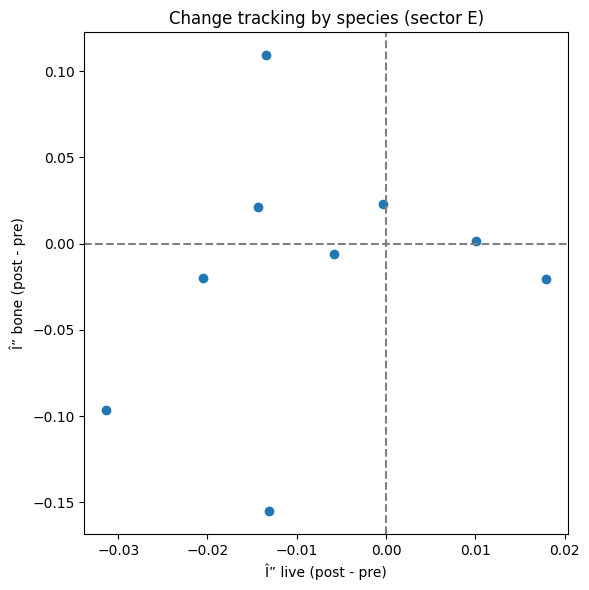

In [215]:
example_sector = list(delta_store.keys())[0]
example_live, example_bone = delta_store[example_sector]

plt.figure(figsize=(6,6))
plt.scatter(example_live, example_bone)
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.xlabel('Î” live (post - pre)')
plt.ylabel('Î” bone (post - pre)')
plt.title(f'Change tracking by species (sector {example_sector})')
plt.tight_layout()
plt.show()


## Summary of results

- **OPC-wide (2008+):** Interpret Bray-Curtis and correlations to state whether bones reflect living community.
- **East vs West:** Compare sector-specific distances to conclude closer matches.
- **Aerial pre vs post 2007:** Summarise PERMANOVA and Bray-Curtis differences.
- **Bone change tracking:** Discuss whether bone shifts align with aerial shifts in direction and magnitude.